# Libraries, Modules, and Configuration File

In [188]:
import pandas as pd
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime
from tqdm import tqdm
import json
import copy
import hashlib

import sys
sys.path.append('/root/ml_process_feb23/')
import src.util as utils
config = utils.load_config()

# Load the Datasets

In [189]:
def load_datasets(config):

    df_train = utils.pkl_load(config['dataset_modelling_path'][0])
    x_train = df_train.drop(['card'], axis = 1)
    y_train = df_train['card']

    df_valid = utils.pkl_load(config['dataset_modelling_path'][1])
    x_valid = df_valid.drop(['card'], axis = 1)
    y_valid = df_valid['card']

    df_test = utils.pkl_load(config['dataset_modelling_path'][2])
    x_test = df_test.drop(['card'], axis = 1)
    y_test = df_test['card']

    x_train_rus = utils.pkl_load(config["dataset_train_balanced_path"][0])
    y_train_rus = utils.pkl_load(config["dataset_train_balanced_path"][1])

    x_train_ros = utils.pkl_load(config["dataset_train_balanced_path"][2])
    y_train_ros = utils.pkl_load(config["dataset_train_balanced_path"][3])

    x_train_smote = utils.pkl_load(config["dataset_train_balanced_path"][4])
    y_train_smote = utils.pkl_load(config["dataset_train_balanced_path"][5])

    return x_train, y_train, \
           x_valid, y_valid, \
           x_test, y_test, \
           x_train_rus, y_train_rus, \
           x_train_ros, y_train_ros, \
           x_train_smote, y_train_smote

In [190]:
# Execute the function for loading datasets 

x_train, y_train, \
x_valid, y_valid, \
x_test, y_test, \
x_train_rus, y_train_rus, \
x_train_ros, y_train_ros, \
x_train_smote, y_train_smote = load_datasets(config)

## Selecting features to be trained

In [191]:
# Checking all the predictors
x_train.columns.values

array(['reports', 'age', 'share', 'owner', 'selfemp', 'dependents',
       'majorcards', 'active', 'income_log', 'expenditure_log',
       'months_log', 'age_bin', 'reports_bin', 'dependents_bin',
       'active_bin'], dtype=object)

In [192]:
# Create instances for some binned features and its original value
bins = config["binned_cols"]
ori_value = config["original_cols"]

For the **baseline model**, I use the features with original value.

In [193]:
# Create the independent variables for baseline model
x_train_base = x_train.drop(bins, axis = 1)
x_train_rus_base = x_train_rus.drop(bins, axis = 1)
x_train_ros_base = x_train_ros.drop(bins, axis = 1)
x_train_smote_base = x_train_smote.drop(bins, axis = 1)
x_valid_base = x_valid.drop(bins, axis = 1)
x_test_base = x_test.drop(bins, axis = 1)

For the **alternative model**, I use the binned features.

In [194]:
# Create the independent variables for alternative model
x_train_bin = x_train.drop(ori_value, axis = 1)
x_train_rus_bin = x_train_rus.drop(ori_value, axis = 1)
x_train_ros_bin = x_train_ros.drop(ori_value, axis = 1)
x_train_smote_bin = x_train_smote.drop(ori_value, axis = 1)
x_valid_bin = x_valid.drop(ori_value, axis = 1)
x_test_bin = x_test.drop(ori_value, axis = 1)

# Create Log Template

In [195]:
def time_stamp():
    return datetime.now()

In [196]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "accuracy" :[],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [197]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

# Training and Evaluation

## Create Model Object

Create instance for each algorithm function

In [198]:
lgr      = LogisticRegression(random_state = 12)      # Logistic regression
svm      = SVC(random_state = 23)                     # Support Vector Machine 
dct      = DecisionTreeClassifier(random_state = 34)  # Decision tree Classifier
rfc      = RandomForestClassifier(random_state = 45)  # Random Forest Classifier
knn      = KNeighborsClassifier()                     # k-Nearest Neighbors CLassifier
xgb      = XGBClassifier(random_state = 67)           # XG Boost Classifier
nb_cat   = CategoricalNB()                            # Categorical Naive Bayes Classifier
nb_gauss = GaussianNB()                               # Gaussian Naive Bayes Classifier

In [199]:
list_of_model = {
    "imbalanced" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "undersampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    }

In [200]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["accuracy"].append(performance["accuracy"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

In [201]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["accuracy", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

## Train and Evaluate the Baseline Models

### Original (imbalanced) data

In [203]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "baseline_model",
    x_train_base,
    y_train,
    "imbalanced",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


In [204]:
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

### Balanced with undersampling

In [205]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "baseline_model",
    x_train_rus_base,
    y_train_rus,
    "undersampling",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

100%|██████████| 8/8 [00:00<00:00,  8.26it/s]


In [206]:
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

### Balanced with oversampling

In [207]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_train_ros_base,
    y_train_ros,
    "oversampling",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  4.03it/s]


In [208]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

### Balanced with SMOTE

In [209]:
training_log, list_of_model_smote = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_train_smote_base,
    y_train_smote,
    "smote",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:02<00:00,  3.18it/s]


In [210]:
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

### Table of models performance

Now let's compare the performance from each algorithm and each dataset.

In [211]:
training_res_baseline = training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00,  7.06it/s]


In [212]:
training_res_baseline

,model_name,model_uid,training_time,training_date,performance,accuracy,f1_score_avg,data_configurations
0,baseline_model-LogisticRegression,9fe9472cca2173099e52ff7799228dd4,0.058174,2023-04-14 13:19:18.736368,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
1,baseline_model-GaussianNB,4dd934263a98805c342915324bdf7b48,0.076112,2023-04-14 13:19:19.612822,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
2,baseline_model-XGBClassifier,8b79c80416f9bb8293d23fe870bea023,0.081466,2023-04-14 13:19:19.478143,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
3,baseline_model-GaussianNB,f9792b4e89c7e20ffafac201ae775316,0.140206,2023-04-14 13:19:22.131074,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,oversampling
4,baseline_model-GaussianNB,78e3bdb50c7b5640fd52b5195f26fabd,0.156368,2023-04-14 13:19:31.064764,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,smote
5,baseline_model-XGBClassifier,dc6961d12f2c3b3a8d1a092a2493cc19,0.162751,2023-04-14 13:19:30.840099,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,smote
6,baseline_model-LogisticRegression,f553a937c5af659553533a843248607b,0.170718,2023-04-14 13:19:20.299823,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,oversampling
7,baseline_model-XGBClassifier,75212232ec1945d7f6f599a2343effa4,0.370705,2023-04-14 13:19:21.702431,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,oversampling
8,baseline_model-GaussianNB,824231d8de637e07616ef3300a3660b2,0.448568,2023-04-14 13:19:17.516221,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,imbalanced
9,baseline_model-RandomForestClassifier,a4dad13293e0fcba51a2416ab20cd7c9,0.481393,2023-04-14 13:19:18.900577,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling


### Interpretation



In [213]:
best_acc = training_res_baseline.loc[0, "accuracy"]
best_acc
print(f"From the baseline models, the best accuracy value is {best_acc}")

From the baseline models, the best accuracy value is 0.9945945945945946


I set the training time threshold for the best models at 0.1 second, thus the models taken from the baseline to be tuned further are:

In [214]:
best_model_base =  training_res_baseline.loc[(training_res_baseline.training_time < 0.1) & \
                                             (training_res_baseline.accuracy == best_acc)]
best_model_base

,model_name,model_uid,training_time,training_date,performance,accuracy,f1_score_avg,data_configurations
0,baseline_model-LogisticRegression,9fe9472cca2173099e52ff7799228dd4,0.058174,2023-04-14 13:19:18.736368,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
1,baseline_model-GaussianNB,4dd934263a98805c342915324bdf7b48,0.076112,2023-04-14 13:19:19.612822,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
2,baseline_model-XGBClassifier,8b79c80416f9bb8293d23fe870bea023,0.081466,2023-04-14 13:19:19.478143,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling


## Train and Evaluate the Alternative Models

The binned value features are used in the datasets for this model training process. 

### Original (imbalanced) data


In [215]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "alternative_model",
    x_train_bin,
    y_train,
    "imbalanced",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


In [216]:
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)


### Balanced with undersampling


In [217]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "alternative_model",
    x_train_rus_bin,
    y_train_rus,
    "undersampling",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)


100%|██████████| 8/8 [00:02<00:00,  3.36it/s]


### Balanced with oversampling


In [218]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "alternative_model",
    x_train_ros_bin,
    y_train_ros,
    "oversampling",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

100%|██████████| 8/8 [00:01<00:00,  4.35it/s]


In [219]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)


### Balanced with SMOTE


In [220]:
training_log, list_of_model_smote = train_eval_model(
    list_of_model["smote"],
    "alternative_model",
    x_train_smote_bin,
    y_train_smote,
    "smote",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


In [221]:
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

### Table of models performance

Now let's compare the performance from each algorithm and each dataset.


In [222]:
training_res_alternative = training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00, 180.12it/s]


In [223]:
training_res_alternative

,model_name,model_uid,training_time,training_date,performance,accuracy,f1_score_avg,data_configurations
0,alternative_model-SVC,b3cd74f209feb615b03f275126a4cc44,0.004817,2023-04-14 13:19:43.739554,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,oversampling
1,alternative_model-DecisionTreeClassifier,a91fae7cbab42616814e1251ca4a640a,0.008015,2023-04-14 13:19:43.772859,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,oversampling
2,alternative_model-DecisionTreeClassifier,1e316e1a8bbcc896112576265d2da7b6,0.027660,2023-04-14 13:19:47.230505,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,smote
3,alternative_model-LogisticRegression,f7a867d8828416b4f49b4aa3ed367d55,0.043233,2023-04-14 13:19:40.844404,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
4,alternative_model-SVC,234dbb1491a67bcb7b1154331cb058ca,0.047520,2023-04-14 13:19:46.959854,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,smote
5,alternative_model-LogisticRegression,e08fdc1d1ac4ccd4e61c2c06b6dbe843,0.065410,2023-04-14 13:19:43.660741,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,oversampling
6,alternative_model-LogisticRegression,98a575eccd6a4de761fef8dc1273138c,0.071112,2023-04-14 13:19:34.331141,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,imbalanced
7,alternative_model-GaussianNB,43b49ac8647aabb1a869dbd7eff6a6c5,0.139947,2023-04-14 13:19:43.056018,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
8,alternative_model-LogisticRegression,63af1e1cdacf1fc7bcb0f8f90964de0d,0.149506,2023-04-14 13:19:46.757901,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,smote
9,alternative_model-XGBClassifier,5ce13979b1cb1fd1137b583c80013d69,0.331522,2023-04-14 13:19:35.324665,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,imbalanced


### Interpretation

In [224]:
best_acc = training_res_alternative.loc[0, "accuracy"]
best_acc
print(f"From the alternative models, the best accuracy value is {best_acc}")

From the alternative models, the best accuracy value is 0.9945945945945946


I set the training time threshold for the best models at 0.1 second, thus the models taken from the baseline to be tuned further are:

In [225]:
best_model_alt = training_res_alternative.loc[(training_res_alternative.training_time < 0.1) & \
                                              (training_res_alternative.accuracy == best_acc)]
best_model_alt                                     

,model_name,model_uid,training_time,training_date,performance,accuracy,f1_score_avg,data_configurations
0,alternative_model-SVC,b3cd74f209feb615b03f275126a4cc44,0.004817,2023-04-14 13:19:43.739554,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,oversampling
1,alternative_model-DecisionTreeClassifier,a91fae7cbab42616814e1251ca4a640a,0.008015,2023-04-14 13:19:43.772859,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,oversampling
2,alternative_model-DecisionTreeClassifier,1e316e1a8bbcc896112576265d2da7b6,0.027660,2023-04-14 13:19:47.230505,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,smote
3,alternative_model-LogisticRegression,f7a867d8828416b4f49b4aa3ed367d55,0.043233,2023-04-14 13:19:40.844404,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
4,alternative_model-SVC,234dbb1491a67bcb7b1154331cb058ca,0.047520,2023-04-14 13:19:46.959854,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,smote
5,alternative_model-LogisticRegression,e08fdc1d1ac4ccd4e61c2c06b6dbe843,0.065410,2023-04-14 13:19:43.660741,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,oversampling
6,alternative_model-LogisticRegression,98a575eccd6a4de761fef8dc1273138c,0.071112,2023-04-14 13:19:34.331141,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,imbalanced


## Hyperparameter Tuning

The models taken from each list of models to be fine-tuned are:

Baseline Models

In [226]:
best_model_base[['model_name', 'data_configurations']]

,model_name,data_configurations
0,baseline_model-LogisticRegression,undersampling
1,baseline_model-GaussianNB,undersampling
2,baseline_model-XGBClassifier,undersampling


Alternative Models

In [227]:
best_model_alt[['model_name', 'data_configurations']]

,model_name,data_configurations
0,alternative_model-SVC,oversampling
1,alternative_model-DecisionTreeClassifier,oversampling
2,alternative_model-DecisionTreeClassifier,smote
3,alternative_model-LogisticRegression,undersampling
4,alternative_model-SVC,smote
5,alternative_model-LogisticRegression,oversampling
6,alternative_model-LogisticRegression,imbalanced


### Create the Paramaters Instances

#### Logistic Regression

In [228]:
# Create parameters instance for Random Forest Classifier algorithm
params1 = {
    'penalty'           : ['l2', None],
    'multi_class'       : ['ovr', 'multinomial'],
    'class_weight'      : ['balanced', None]
}

In [229]:
# Search the best parameters for Logistic Regression algorithm
grid_search1 = GridSearchCV(lgr, params1)
random_search1 = RandomizedSearchCV(lgr, params1, random_state = 85)

#### Gaussian Naive Bayes

In [230]:
# Create parameters instance for Gaussian Naive Bayes algorithm
params2 = {
    'var_smoothing'           : [1e-9, 1e-10, 1e-11, 1e-12]
}

In [231]:
# Search the best parameters for Gaussian Naive Bayes algorithm
grid_search2 = GridSearchCV(nb_gauss, params2)
random_search2 = RandomizedSearchCV(nb_gauss, params2, random_state = 86)

#### Support Vector Machine

In [232]:
# Create parameters instance for Support Vector Machine algorithm
params3 = {
    'kernel'                    : ['linear', 'poly', 'rbf'],
    'probability'               : [True, False],
    'decision_function_shape'   : ['ovr', 'ovo'],
    'class_weight'              : ['balanced', None]
}

In [233]:
# Search the best parameters for Support Vector Machine algorithm
grid_search3 = GridSearchCV(svm, params3)
random_search3 = RandomizedSearchCV(svm, params3, random_state = 87)

#### Decision Tree Classifier

In [234]:
# Create parameters instance for Decision Tree Classifier algorithm
params4 = {
    'criterion'         : ['gini', 'entropy', 'log_loss'],
    'splitter'          : ['best', 'random'],
    'max_features'      : ['sqrt', 'log2', None],
    'class_weight'      : ['balanced', None]
}

In [235]:
# Search the best parameters for Decision Tree Classifier algorithm
grid_search4 = GridSearchCV(dct, params4)
random_search4 = RandomizedSearchCV(dct, params4, random_state = 88)

#### XG Boost

In [236]:
# Create parameters instance for XG Boost algorithm
params5 = {
    'an_estimators'      : [50, 100, 200, 300],
    'booster'           : ['gbtree', 'dart'],
    'tree_method'       : ['exact', 'approx', 'hist']
}

In [237]:
# Search the best parameters for XG Boost algorithm
grid_search5 = GridSearchCV(xgb, params5)
random_search5 = RandomizedSearchCV(xgb, params5, random_state = 86)

### Train the Tuned Models



The list in these models will contain both of the default parameters of the algorithm and the tuned ones.

In [238]:
# Create new list of models

list_of_model_tuned = {
    "undersampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": grid_search1.__class__.__name__ + "-" + grid_search1.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search1), "model_uid": ""},
        { "model_name": random_search1.__class__.__name__ + "-" + random_search1.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search1), "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": grid_search1.__class__.__name__ + "-" + grid_search1.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search1), "model_uid": ""},
        { "model_name": random_search1.__class__.__name__ + "-" + random_search1.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search1), "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": grid_search3.__class__.__name__ + "-" + grid_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search3), "model_uid": ""},
        { "model_name": random_search3.__class__.__name__ + "-" + random_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search3), "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": grid_search4.__class__.__name__ + "-" + grid_search4.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search4), "model_uid": ""},
        { "model_name": random_search4.__class__.__name__ + "-" + random_search4.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search4), "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": grid_search1.__class__.__name__ + "-" + grid_search1.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search1), "model_uid": ""},
        { "model_name": random_search1.__class__.__name__ + "-" + random_search1.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search1), "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": grid_search3.__class__.__name__ + "-" + grid_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search3), "model_uid": ""},
        { "model_name": random_search3.__class__.__name__ + "-" + random_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search3), "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": grid_search4.__class__.__name__ + "-" + grid_search4.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search4), "model_uid": ""},
        { "model_name": random_search4.__class__.__name__ + "-" + random_search4.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search4), "model_uid": ""}
        ],
    }

In [239]:
training_log, list_of_model_tuned_rus = train_eval_model(
    list_of_model_tuned["undersampling"],
    "baseline_model",
    x_train_rus_base,
    y_train_rus,
    "undersampling",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_tuned.json"
)
list_of_model_tuned["undersampling"] = copy.deepcopy(list_of_model_tuned_rus)

 33%|███▎      | 1/3 [00:00<00:00,  7.01it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit

In [240]:
training_log, list_of_model_tuned_rus = train_eval_model(
    list_of_model_tuned["undersampling"],
    "alternative_model",
    x_train_rus_bin,
    y_train_rus,
    "undersampling",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_tuned.json"
)
list_of_model_tuned["undersampling"] = copy.deepcopy(list_of_model_tuned_rus)


  0%|          | 0/3 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

In [241]:
training_log, list_of_model_tuned_ros = train_eval_model(
    list_of_model_tuned["oversampling"],
    "alternative_model",
    x_train_ros_bin,
    y_train_ros,
    "oversampling",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_tuned.json"
)
list_of_model_tuned["oversampling"] = copy.deepcopy(list_of_model_tuned_ros)

  0%|          | 0/9 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

In [242]:
training_log, list_of_model_tuned_smote = train_eval_model(
    list_of_model_tuned["smote"],
    "alternative_model",
    x_train_smote_bin,
    y_train_smote,
    "smote",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_tuned.json"
)
list_of_model_tuned["smote"] = copy.deepcopy(list_of_model_tuned_smote)

 11%|█         | 1/9 [00:00<00:00,  9.64it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit

### Table of models performance

In [243]:
training_res_tuned = training_log_to_df(training_log)


100%|██████████| 4/4 [00:00<00:00, 86.32it/s]


In [244]:
training_res_tuned

,model_name,model_uid,training_time,training_date,performance,accuracy,f1_score_avg,data_configurations
0,alternative_model-DecisionTreeClassifier,98cac8dffd0028f6121f45763c1e6019,0.009100,2023-04-14 13:20:42.773864,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,oversampling
1,alternative_model-SVC,bb695f8a337f0a5e865268941aec5477,0.010735,2023-04-14 13:20:27.513186,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,oversampling
2,alternative_model-DecisionTreeClassifier,aebe92555dd3d9990aec84923297e561,0.012882,2023-04-14 13:21:19.056752,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,smote
3,alternative_model-SVC,f5f0aab12ca8cbadbc98ff0f599cbdcc,0.014174,2023-04-14 13:21:05.331547,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,smote
4,alternative_model-LogisticRegression,47af52b96f5d11043d6ffb094986a782,0.031486,2023-04-14 13:20:08.640183,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
5,alternative_model-LogisticRegression,5fe5bc93f09b96bdb2374ec34201cc6a,0.049555,2023-04-14 13:20:18.215557,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,oversampling
6,alternative_model-LogisticRegression,5f753f12a8f3a8cdaae20e67f11247cd,0.070164,2023-04-14 13:20:51.906724,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,smote
7,baseline_model-LogisticRegression,2b790f549392535adfa2b9b346430a71,0.096144,2023-04-14 13:20:01.422117,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
8,alternative_model-RandomizedSearchCV-DecisionT...,d1d78ff5ba9d556115ee402ce8250b21,0.768690,2023-04-14 13:21:25.249394,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,smote
9,baseline_model-RandomizedSearchCV-LogisticRegr...,050a9165271b61ba5d464f8451b1afef,1.996765,2023-04-14 13:20:05.673565,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling


### Best Model

As seen in the table above, the hyperparameter tuning did not improve the performance, the best model is still the same with the result in the alternative models table.

The best model now will be saved for further deployment process.

In [245]:
def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["accuracy", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object

In [246]:
best_model = get_best_model(training_res_tuned, list_of_model_tuned)

import joblib
joblib.dump(best_model, "/root/ml_process_feb23/models/best_model.pkl")

best_model

DecisionTreeClassifier(random_state=34)

#### Metrics Analysis

After choosing the best model, let's check the confusion matrix and classification report to analyze the model. 

In [247]:
# Create instance for the predicted target
y_pred = best_model.predict(x_valid_bin)


              precision    recall  f1-score   support

           0   1.000000  0.976190  0.987952        42
           1   0.993056  1.000000  0.996516       143

    accuracy                       0.994595       185
   macro avg   0.996528  0.988095  0.992234       185
weighted avg   0.994632  0.994595  0.994571       185



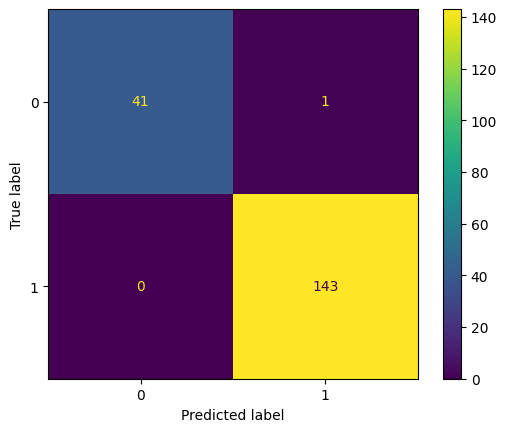

In [248]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
print(classification_report(y_valid, y_pred, digits = 6))

In credit card approval prediction, it is crucial to predict correctly the **accuracy score**, which means the machine learning model is able to predict the approval status of the applications as approved that originally got approved, and vice versa.

If the defect in credit card approval prediction can be kept at a very low level, the credit card issuer will not have a problem handling the credit default status.

In [249]:
report_on_valid = classification_report(y_valid, y_pred, output_dict = True)
acc_on_valid = report_on_valid["accuracy"]

print(f"The accuracy score on validation datasets is: {round(acc_on_valid, 6)},\nwhich is considered a high score")

The accuracy score on validation datasets is: 0.994595,
which is considered a high score


## Evaluation

Now let's implicate the testing dataset to evaluate the chosen model's performance.

In [250]:
y_pred_eval = best_model.predict(x_test_bin)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        50
           1       0.99      0.97      0.98       174

    accuracy                           0.97       224
   macro avg       0.95      0.98      0.96       224
weighted avg       0.97      0.97      0.97       224



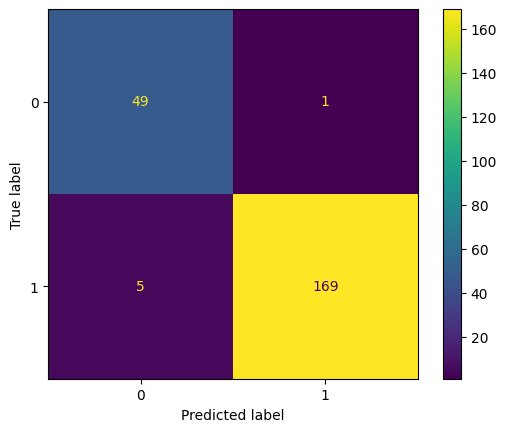

In [251]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_eval)
print(classification_report(y_test, y_pred_eval))

In [252]:
report_on_test = classification_report(y_test, y_pred_eval, output_dict = True, digits = 6)
acc_on_test = report_on_test["accuracy"]

print(f"The accuracy score on testing datasets is: {round(acc_on_test, 6)}")

The accuracy score on testing datasets is: 0.973214


In [259]:
print(f"The accuracy score difference between testing and validation datasets is: {round(acc_on_test - acc_on_valid, 6)}")

The accuracy score difference between testing and validation datasets is: -0.02138


When the model is applied to the testing datasets which contain more data than the validation one, it performs worse, the accuracy score decrease in a tolerable value.